In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import re

import string

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import top_k_accuracy_score, accuracy_score
from textblob import TextBlob 
from textblob import Word

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from langdetect import detect
from deep_translator import GoogleTranslator  

from joblib import dump, load

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [200]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 3)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0., 1.0)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [260]:
X_train = pd.read_csv("../../raw_data/X_train_fully_pp.csv")["spellchecked_title"].astype(str)
y_train = pd.read_csv("../../raw_data/train_y.csv", delimiter=" ", index_col="Id")['Genre_id']
X_test = pd.read_csv("../../raw_data/X_test_fully_pp.csv")["spellchecked_title"].astype(str)
y_test = pd.read_csv("../../raw_data/test_y.csv", delimiter=" ", index_col="Id")['Genre_id']

In [232]:
def preprocessed_title(titles):
#     output = titles.str.lower()
#     output = output.apply(lambda x: "".join([i for i in x if i not in string.punctuation]))
#     output = output.apply(lambda x: "".join([i for i in x if i not in string.digits]))
#     output = output.apply(lambda x: re.split('\W+', x))
    #output = output.apply(lambda x: [str(TextBlob(word).correct()) for word in x])
    output = titles.str.split()
    porter_stemmer = PorterStemmer()
    output = output.apply(lambda x: [porter_stemmer.stem(word) for word in x])
    stops = set(stopwords.words('english'))
    output = output.apply(lambda x: [word for word in x if word not in stops])
    output = output.apply(lambda x: [word for word in x if len(word) > 2])

    return output

In [233]:
X_train_preproc = preprocessed_title(X_train)
X_test_preproc= preprocessed_title(X_test)

In [234]:
X_train

0        comet example and sa sported royals gentle twi...
1                   magnets pulling together pushing apart
2        energy security volume sage library of interna...
3        audiobook mpcd insert transfer listen trees an...
4              city of rocks idaho a climbers guide untale
                               ...                        
51295    john sanford new york timesbestselling author ...
51296    second edition the crime writers guide to poli...
51297               the jezebel remedy a nord martin clark
51298                                 glenn oguras startup
51299    bad karaden the mystery mystery ender killer t...
Name: spellchecked_title, Length: 51300, dtype: object

In [235]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_preproc)
X_train_token = tokenizer.texts_to_sequences(X_train_preproc)
X_test_token = tokenizer.texts_to_sequences(X_test_preproc)

In [236]:
# dump(tokenizer, "../../models/vectorizers/basic_tokenizer.pkl")

In [237]:
X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='post', value=0, maxlen=60)
X_test_pad = pad_sequences(X_test_token, dtype='float32', padding='post', value=0, maxlen=60)
X_train_pad.shape

(51300, 60)

In [238]:
y_train_cat = to_categorical(y_train, num_classes=30)
y_test_cat = to_categorical(y_test, num_classes=30)
y_train_cat.shape

(51300, 30)

In [239]:
vocab_size = len(tokenizer.word_counts)
vocab_size

59220

In [240]:
def initialize_model():
    model = Sequential()
    model.add(layers.Embedding(
        input_dim=vocab_size+1, # 16 +1 for the 0 padding
        output_dim=100,
        input_length=60,
        mask_zero=True, # Built-in masking layer :)
    ))

    model.add(layers.Conv1D(100, kernel_size=3))

    model.add(layers.Flatten())
    
    model.add(layers.Dense(100, activation="relu", kernel_regularizer="l2"))
    model.add(layers.Dropout(0.35))

    model.add(layers.Dense(30, activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

    return model

In [241]:
model_cnn = initialize_model()

es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy")

history = model_cnn.fit(X_train_pad, y_train_cat,
              epochs=1000,
              batch_size=16,
              validation_split=0.1,
              callbacks=[es]
             )


res = model_cnn.evaluate(X_test_pad, y_test_cat, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

Epoch 1/1000
2886/2886 [==============================] - 70s 24ms/step - loss: 3.0833 - accuracy: 0.1225 - val_loss: 2.8147 - val_accuracy: 0.1509
Epoch 2/1000
2886/2886 [==============================] - 59s 21ms/step - loss: 2.6881 - accuracy: 0.2314 - val_loss: 2.7585 - val_accuracy: 0.1858
Epoch 3/1000
2886/2886 [==============================] - 54s 19ms/step - loss: 2.5101 - accuracy: 0.2982 - val_loss: 2.6845 - val_accuracy: 0.2314
Epoch 4/1000
2886/2886 [==============================] - 52s 18ms/step - loss: 2.3520 - accuracy: 0.3577 - val_loss: 2.7411 - val_accuracy: 0.2606
Epoch 5/1000
2886/2886 [==============================] - 66s 23ms/step - loss: 2.2142 - accuracy: 0.4128 - val_loss: 2.8468 - val_accuracy: 0.2786
Epoch 6/1000
2886/2886 [==============================] - 61s 21ms/step - loss: 2.0827 - accuracy: 0.4606 - val_loss: 2.7833 - val_accuracy: 0.2885
Epoch 7/1000
2886/2886 [==============================] - 51s 18ms/step - loss: 1.9460 - accuracy: 0.5038 - val_

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

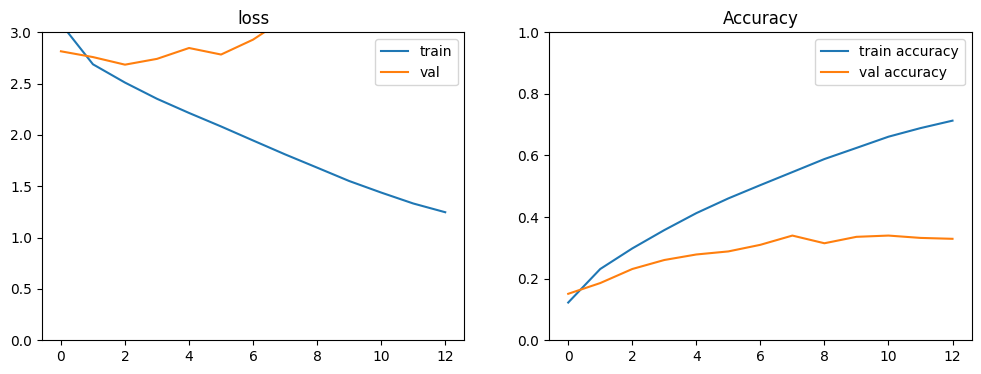

In [242]:
plot_history(history)

In [246]:
y_pred_full = model_cnn.predict(X_test_pad)
y_pred = np.argmax(y_pred_full, axis=1)

179/179 [==============================] - 1s 3ms/step


In [247]:
top_k_accuracy = top_k_accuracy_score(y_test, y_pred_full, k=3)
print(f'Top 3 accuracy: {top_k_accuracy*100:.2f}%')

Top 3 accuracy: 55.82%


In [248]:
dump(model_cnn, "../../models/cover_nlp.pkl")

['../../models/cover_nlp.pkl']

In [249]:
text = X_train[0]

In [250]:
nltk_results = ne_chunk(pos_tag(word_tokenize(text)))
for nltk_result in nltk_results:

    if isinstance(nltk_result, nltk.Tree):
        name = ''
        type(nltk_result)
        for nltk_result_leaf in nltk_result.leaves():
            name += nltk_result_leaf[0] + ' '
        print ('Type: ', nltk_result.label(), 'Name: ', name)

In [ ]:
nltk_results

In [ ]:
def translate(text):
    try:
        result_lang = detect(text.lower())
        if result_lang != "en":
            translator = GoogleTranslator(source='auto', target='en')
            text = translator.translate(text)
        return text
    except: 
        return text

X_train_translated = X_train.apply(translate)
X_train_translated

In [202]:
X_train_full = pd.read_csv("../../raw_data/titles_train.csv")

X_train_full["translated_title"] = X_train_translated

X_train_full.to_csv("../../raw_data/titles_train.csv", header=True, index=False)

NameError: name 'X_train_translated' is not defined

In [203]:
X_train_test = X_train[:10]

In [204]:
import logging
import sys
from urllib.parse import quote

from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

options = Options()
options.add_argument('--headless')

# logging.basicConfig(level=logging.INFO)
log = logging.getLogger()

def did_you_mean(query, source_language="auto"):
    """
    Spell-checks a sentence.

    :param query: an input sentence to spellcheck.
    :param source_language: a specific language to translate from. Defaults to automated language detection.

    :return: the query after applying suggestions, or unmodified if none is found.
    """

    driver = webdriver.Chrome(options=options)
    query = str(query).strip()
    url = "https://translate.google.com/#view=home&op=translate&sl=%s&tl=en&text=" % source_language + quote(query)

    driver.get(url)
    # log.debug(driver.execute_script("return document.documentElement.outerHTML;"))
    div = driver.find_element(By.ID, "spelling-correction")
    log.info("<div>: [%s]" % div.get_attribute('innerHTML'))
    try:
        a = div.find_element_by_tag_name("a")
        a_html = a.get_attribute('innerHTML')
        log.info("<a>: [%s]" % a_html)
        if len(a_html):
            div = a
    except NoSuchElementException:
        pass
    suggestion = div.text.replace("Did you mean:", "").strip()
    log.info("Suggestion: %s" % suggestion)
    return suggestion if len(suggestion) else query

In [205]:
X_train[0]

'comet example and sa sported royals gentle twitter festive effective mary m vice and ng book greet gr energy and ww wherever example as captured welling gen barry b caffrey usa ree women schwarzkopf life lessons of the bear by gus lee bestselling author of courage the backbone of leadership'

In [206]:
did_you_mean(X_train[1])

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"[id="spelling-correction"]"}
  (Session info: headless chrome=114.0.5735.133); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
#0 0x55a3d33704e3 <unknown>
#1 0x55a3d309fc76 <unknown>
#2 0x55a3d30dbc96 <unknown>
#3 0x55a3d30dbdc1 <unknown>
#4 0x55a3d31157f4 <unknown>
#5 0x55a3d30fb03d <unknown>
#6 0x55a3d311330e <unknown>
#7 0x55a3d30fade3 <unknown>
#8 0x55a3d30d02dd <unknown>
#9 0x55a3d30d134e <unknown>
#10 0x55a3d33303e4 <unknown>
#11 0x55a3d33343d7 <unknown>
#12 0x55a3d333eb20 <unknown>
#13 0x55a3d3335023 <unknown>
#14 0x55a3d33031aa <unknown>
#15 0x55a3d33596b8 <unknown>
#16 0x55a3d3359847 <unknown>
#17 0x55a3d3369243 <unknown>
#18 0x7f3a50495b43 <unknown>


In [32]:
type(X_test_pad[10])

numpy.ndarray

In [34]:
X_test_pad[10].shape

(60,)

In [40]:
input_sample = np.reshape(X_test_pad[10], (1, 60))

In [41]:
model_cnn.predict(input_sample)

1/1 [==============================] - 0s 17ms/step


array([[1.0171208e-10, 2.5049408e-06, 1.1682365e-06, 4.3379714e-12,
        5.4545660e-11, 3.2455358e-11, 3.6580172e-10, 8.2595146e-12,
        3.2490341e-08, 9.4794674e-04, 2.8215767e-12, 1.4276843e-01,
        7.7457363e-10, 2.6433878e-07, 1.4791925e-08, 3.3638412e-07,
        4.3764588e-04, 7.5999321e-07, 3.9532414e-01, 1.1573813e-04,
        3.8469352e-07, 7.7600154e-04, 3.7985749e-06, 5.5556043e-08,
        3.5050868e-11, 4.5565626e-01, 8.5859809e-12, 3.9596371e-03,
        4.9694650e-06, 1.9614892e-15]], dtype=float32)

In [12]:
from selenium import webdriver
import chromedriver_binary

driver = webdriver.Chrome()
driver.get("https://recipes.lewagon.com/recipes/advanced")

In [ ]:
from math import log

# Build a cost dictionary, assuming Zipf's law and cost = -math.log(probability).
words = open("words-by-frequency.txt").read().split()
wordcost = dict((k, log((i+1)*log(len(words)))) for i,k in enumerate(words))
maxword = max(len(x) for x in words)

def infer_spaces(s):
    """Uses dynamic programming to infer the location of spaces in a string
    without spaces."""

    # Find the best match for the i first characters, assuming cost has
    # been built for the i-1 first characters.
    # Returns a pair (match_cost, match_length).
    def best_match(i):
        candidates = enumerate(reversed(cost[max(0, i-maxword):i]))
        return min((c + wordcost.get(s[i-k-1:i], 9e999), k+1) for k,c in candidates)

    # Build the cost array.
    cost = [0]
    for i in range(1,len(s)+1):
        c,k = best_match(i)
        cost.append(c)

    # Backtrack to recover the minimal-cost string.
    out = []
    i = len(s)
    while i>0:
        c,k = best_match(i)
        assert c == cost[i]
        out.append(s[i-k:i])
        i -= k

    return " ".join(reversed(out))

In [47]:
def preprocessed_title_test(titles):
    output = titles.str.lower()
    output = output.apply(lambda x: "".join([i for i in x if i not in string.punctuation]))
    output = output.apply(lambda x: "".join([i for i in x if i not in string.digits]))
    output = output.apply(lambda x: re.split('\W+', x))
#     porter_stemmer = PorterStemmer()
#     output = output.apply(lambda x: [porter_stemmer.stem(word) for word in x])
#     stops = set(stopwords.words('english'))
#     output = output.apply(lambda x: [word for word in x if word not in stops])

    return output

In [10]:
from spellchecker import SpellChecker

In [11]:
spell = SpellChecker()

In [21]:
misspelled = spell.unknown(X_train[9].split())
misspelled

{'carsten', "ireland's", 'krieger'}

In [22]:
for word in misspelled:
    # Get the one `most likely` answer
    print(spell.correction(word))

    # Get a list of `likely` options
    print(spell.candidates(word))

island's
{'ireland', "roland's", "island's", "leland's"}
trigger
{'ringer', 'rigger', 'trigger', 'wringer', 'briefer', 'bringer'}
cartel
{'fasten', 'caster', 'austen', 'chasten', 'casted', 'cartel', 'larsen', 'carter', 'carted', 'kirsten', 'hasten', 'marten', 'carmen', 'castes', 'carte', 'oarsmen', 'careen', 'carson', 'christen', 'caste', 'carlton', 'carton'}


In [56]:
preproc = preprocessed_title_test(X_train[:10])

In [130]:
def spell_check(text):
    spell = SpellChecker()
    misspelled = spell.unknown(text)

    fixed_words = []
    for word in misspelled:
        candidates = spell.candidates(word)
        if candidates is not None and len(candidates) <= 5:
            correction = spell.correction(word)
            text = [correction if token == word else token for token in text]
            fixed_words.append(word)

    misspelled.difference_update(fixed_words)

    text_copy = text.copy()
    for i, word in enumerate(text_copy[:-1]):
        if word in misspelled and text_copy[i+1] in misspelled:
            combo_word = word + text_copy[i+1]
            candidates = spell.candidates(combo_word)
            if candidates is not None and len(candidates) <= 3:
                text[i] = spell.correction(combo_word)
                text[i+1] = ""

    text = [word for word in text if word != ""]
    return text

In [131]:
spell_check(preproc[0])

['comet',
 'example',
 'and',
 'sa',
 'sported',
 'royals',
 'gentle',
 'twitter',
 'festive',
 'effective',
 'mary',
 'm',
 'vice',
 'and',
 'ng',
 'book',
 'greet',
 'gr',
 'energy',
 'and',
 'ww',
 'wherever',
 'example',
 'as',
 'captured',
 'welling',
 'gen',
 'barry',
 'b',
 'caffrey',
 'usa',
 'ree',
 'women',
 'schwarzkopf',
 'life',
 'lessons',
 'of',
 'the',
 'bear',
 'by',
 'gus',
 'lee',
 'bestselling',
 'author',
 'of',
 'courage',
 'the',
 'backbone',
 'of',
 'leadership']

In [132]:
X_train[0].split()

['Colet',
 'example,',
 'and',
 'SA',
 'sported',
 'ronals',
 'Gentl',
 'Twitte',
 'festive)',
 'efetive',
 'mary',
 'm',
 'vice',
 'and',
 'ng',
 'book',
 'greet',
 'gr',
 'energ',
 'and',
 'ww.',
 'wheredar',
 'exampl',
 'as',
 'captured',
 'wellin',
 'GEN,',
 'BARRY',
 'B.',
 'MCCAFFREY,',
 'USA',
 'REE',
 'WONEN',
 'Schwarzkopf',
 '***',
 'Life',
 'Lessons',
 'of',
 'The',
 'BEAR',
 'by',
 'GUS',
 'LEE',
 'Best-selling',
 'author',
 'of',
 'Courage:',
 'The',
 'Backbone',
 'of',
 'Leadership']

In [256]:
train_file_path = '../../raw_data/tmp_data/y_train_umbr.npy'
test_file_path = '../../raw_data/tmp_data/y_test_umbr.npy'
y_train_um = np.load(train_file_path, allow_pickle=True)[:, 3].astype(int)
y_test_um = np.load(test_file_path, allow_pickle=True)[:, 3].astype(int)

In [257]:
y_train_cat_um = to_categorical(y_train_um, num_classes=30)
y_test_cat_um = to_categorical(y_test_um, num_classes=30)
y_train_cat_um.shape

(51300, 30)

In [258]:
def initialize_model():
    model = Sequential()
    model.add(layers.Embedding(
        input_dim=vocab_size+1, # 16 +1 for the 0 padding
        output_dim=100,
        input_length=60,
        mask_zero=True, # Built-in masking layer :)
    ))

    model.add(layers.Conv1D(100, kernel_size=3))

    model.add(layers.Flatten())
    
    model.add(layers.Dense(100, activation="relu", kernel_regularizer="l2"))
    model.add(layers.Dropout(0.35))

    model.add(layers.Dense(8, activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

    return model

In [259]:
model_cnn = initialize_model()

es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy")

history = model_cnn.fit(X_train_pad, y_train_cat_um,
              epochs=1000,
              batch_size=16,
              validation_split=0.1,
              callbacks=[es]
             )


res = model_cnn.evaluate(X_test_pad, y_test_cat_um, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

Epoch 1/1000


ValueError: in user code:

    File "/home/chris/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/chris/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/chris/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/chris/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/chris/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "/home/chris/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/chris/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/chris/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/chris/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/losses.py", line 1984, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/chris/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/backend.py", line 5559, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 30) and (None, 8) are incompatible


In [ ]:
res = model_cnn.evaluate(X_test_pad, y_test_cat_um, verbose=0)
res[1]*100

In [255]:
dump(model_cnn, "../../models/cover_nlp_8.pkl")

['../../models/cover_nlp_8.pkl']

In [6]:
train_file_path = '../../raw_data/tmp_data/y_train_umbr.npy'
y_train_um = np.load(train_file_path, allow_pickle=True)

In [7]:
y_train_um

array([[1, 'Biographies & Memoirs', 'History & Religion', 0],
       [4, "Children's Books", 'Relationships & Children', 1],
       [10, 'Engineering & Transportation', 'Academic - Science', 2],
       ...,
       [17, 'Mystery, Thriller & Suspense', 'Literature & Entertainment',
        4],
       [17, 'Mystery, Thriller & Suspense', 'Literature & Entertainment',
        4],
       [17, 'Mystery, Thriller & Suspense', 'Literature & Entertainment',
        4]], dtype=object)

In [24]:
dictionary = {}

# Iterate over the array rows
for row in y_train_um:
    key = row[2]  # Value in column 3 as the key
    value = row[1]  # Value in column 2 as the value
    
    if key in dictionary:
        if value not in dictionary[key]:
            dictionary[key].append(value)
    else:
        dictionary[key] = [value]

In [25]:
dictionary

{'History & Religion': ['Biographies & Memoirs',
  'Christian Books & Bibles',
  'Religion & Spirituality',
  'History'],
 'Relationships & Children': ["Children's Books",
  'Parenting & Relationships',
  'Teen & Young Adult',
  'Self-Help'],
 'Academic - Science': ['Engineering & Transportation',
  'Medical Books',
  'Science & Math',
  'Business & Money',
  'Computers & Technology'],
 'Lifestyle & Fitness': ['Sports & Outdoors',
  'Health, Fitness & Dieting',
  'Travel',
  'Cookbooks, Food & Wine'],
 'Academic - Humanities': ['Politics & Social Sciences', 'Law'],
 'Arts & Hobbies': ['Crafts, Hobbies & Home',
  'Arts & Photography',
  'Comics & Graphic Novels',
  'Calendars'],
 'Literature & Entertainment': ['Literature & Fiction',
  'Humor & Entertainment',
  'Romance',
  'Science Fiction & Fantasy',
  'Mystery, Thriller & Suspense'],
 'Academic - Pure': ['Test Preparation', 'Reference']}

In [26]:
num_dict = {}


# Iterate over the array rows
for row in y_train_um:
    key = row[3]  # Value in column 3 as the key
    value = row[0]  # Value in column 2 as the value
    
    if key in num_dict:
        if value not in num_dict[key]:
            num_dict[key].append(value)
    else:
        num_dict[key] = [value]

In [27]:
num_dict

{0: [1, 9, 21, 12],
 1: [4, 18, 27, 25],
 2: [10, 16, 23, 2, 6],
 3: [26, 11, 29, 7],
 5: [19, 14],
 6: [8, 0, 5, 3],
 4: [15, 13, 22, 24, 17],
 7: [28, 20]}

In [22]:
model_30 = load("../../models/cover_nlp.pkl")
model_8 = load("../../models/cover_nlp_8.pkl")

2023-06-21 08:45:37.054202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-21 08:45:37.054782: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [166]:
def top_k_argmax(array, k):
    indexes = np.argpartition(array, -k)[-k:]
    sorted_indexes = indexes[np.argsort(array[indexes])][::-1]
    return sorted_indexes

def top_k_multiline(array, k):
    results = []
    for line in array:
        results.append(top_k_argmax(line, k))
    return np.array(results)

In [189]:
def compound_pred(model_8, model_30, X, mapping):
    pred_8 = np.argmax(model_8.predict(X), axis=1)
    pred_30 = top_k_multiline(model_30.predict(X), 10)
    y_pred = []
    for i, prediction in enumerate(pred_30):
        found_match = False
        for element in prediction:
            if element in mapping[pred_8[i]]:
                y_pred.append(element)
                found_match = True
                break
        if not found_match:
            y_pred.append(prediction[0])
    return np.array(y_pred)
    

In [190]:
np.argmax(model_8.predict(X_test_pad), axis=1)[:100]

179/179 [==============================] - 0s 3ms/step


array([2, 7, 4, 0, 2, 4, 1, 5, 6, 4, 1, 5, 4, 1, 0, 1, 3, 2, 3, 4, 6, 2,
       0, 6, 5, 6, 4, 4, 6, 4, 4, 0, 3, 2, 6, 4, 4, 0, 2, 0, 1, 6, 1, 5,
       1, 2, 2, 0, 3, 6, 1, 3, 6, 0, 0, 0, 6, 1, 1, 0, 5, 4, 3, 3, 6, 1,
       5, 1, 2, 6, 4, 3, 2, 6, 0, 5, 3, 0, 3, 4, 3, 3, 0, 6, 2, 2, 1, 4,
       5, 6, 0, 7, 1, 5, 5, 2, 1, 7, 0, 0])

In [191]:
y_pred = compound_pred(model_8, model_30, X_test_pad, num_dict)

179/179 [==============================] - 1s 3ms/step


In [192]:
y_pred[:100]

array([16, 28, 13, 21, 23, 24, 25, 19,  5, 13, 25, 14, 13, 25,  1, 18,  7,
        6,  7, 13, 12,  2, 12,  3, 14,  8, 13, 22,  5, 24,  2, 12, 29,  6,
        9, 15, 13,  1,  6, 21,  4,  0,  4, 19, 25, 23,  4,  9,  7,  0, 27,
        7,  8, 21, 12,  1,  8, 27, 25, 21, 14, 13, 26, 29,  5, 25, 19, 27,
       16,  8, 13, 29,  6,  8,  1, 19,  7, 12, 11, 13, 29, 11, 12,  8, 16,
        2,  4, 15, 19,  8,  9, 20, 27, 14, 14, 10,  4, 28,  9, 21])

In [193]:
y_test.shape

(5700,)

In [194]:
accuracy_score(y_test, y_pred)

0.39473684210526316